In [1]:
import sys 
sys.path.append("..")
import numpy as np 
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

import hls4ml

from qkeras.qlayers import QDense, QActivation
from qkeras.quantizers import quantized_bits, quantized_relu
from qkeras.utils import _add_supported_quantized_objects

import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
from tensorflow.keras.callbacks import CallbackList
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

from utils.train_utils import config_model, validate, load_data, open_config

2023-03-23 11:52:24.818955: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-23 11:52:24.818979: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/jcampos/miniforge3/envs/hawq-test-env/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libc10_cuda.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [2]:
def load_checkpoint(filename):
    co = {}
    _add_supported_quantized_objects(co)
    model = load_model(filename, custom_objects=co, compile=False)
    return model 


In [3]:
X_test = np.ascontiguousarray(np.load('X_test.npy'))
y_test = np.load('y_test.npy', allow_pickle=True)

model = load_checkpoint('../checkpoints/qkeras/model_best_tr.h5')
y_keras = model.predict(X_test)
print("Checkpoint Test Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))))

2023-03-23 11:52:26.817187: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-23 11:52:26.817220: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-23 11:52:26.817250: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (correlator3.fnal.gov): /proc/driver/nvidia/version does not exist
2023-03-23 11:52:26.817540: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


7500/7500 [==============================] - 17s 2ms/step
Checkpoint Test Accuracy: 0.7278666666666667


In [136]:
hls4ml.model.optimizer.OutputRoundingSaturationMode.layers = ['Activation']
hls4ml.model.optimizer.OutputRoundingSaturationMode.rounding_mode = 'AP_RND'
hls4ml.model.optimizer.OutputRoundingSaturationMode.saturation_mode = 'AP_SAT'

# config = hls4ml.utils.config_from_keras_model(model, granularity='name')
config = hls4ml.utils.config_from_keras_model(model, granularity='name')

config['LayerName']['softmax']['exp_table_t'] = 'ap_fixed<18,8>'
config['LayerName']['softmax']['inv_table_t'] = 'ap_fixed<18,4>'

config['LayerName']['fc2']['Precision']['result'] = 'ap_fixed<8,5>'
# config['LayerName']['relu1']['Precision']['result'] = 'ap_fixed<4,2>'

config['Model']['Precision'] = 'ap_fixed<16,6>'
for layer in config['LayerName'].keys():
    config['LayerName'][layer]['Trace'] = True

print("-----------------------------------")
print("Configuration")
print(config)
print("-----------------------------------")

Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: Input
Layer name: fc1, layer type: QDense
Layer name: relu1, layer type: QActivation
Layer name: fc2, layer type: QDense
Layer name: relu2, layer type: QActivation
Layer name: fc3, layer type: QDense
Layer name: relu3, layer type: QActivation
Layer name: output, layer type: QDense
Layer name: softmax, layer type: Activation
-----------------------------------
Configuration
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'fc1_input': {'Precision': {'result': 'ap_fixed<16,6>'}, 'Trace': True}, 'fc1': {'Precision': {'weight': 'ap_fixed<4,1>', 'bias': 'ap_fixed<4,1>'}, 'ReuseFactor': 1, 'Trace': True}, 'relu1': {'Precision': {'result': 'ap_ufixed<4,2>'}, 'ReuseFactor': 1, 'Trace': True}, 'fc2': {'Precision': {'weight': 'ap_int<2>', 'bias': 'ap_int<2>', 'result': 'ap_fixed<8,5>'}, 'ReuseFactor': 1, 'Trace': True}, 'relu2': {'Precision': {'result': 'ap_ufixed<4,2>'}, 'ReuseF

In [137]:
# # config['LayerName'] = {}
# # config['LayerName']['fc1'] = {}
# # config['LayerName']['fc1_linear'] = {}
# # config['LayerName']['relu1'] = {}
# # config['LayerName']['fc2'] = {}
# # config['LayerName']['fc2_alpha'] = {}
# # config['LayerName']['relu2'] = {}
# # config['LayerName']['fc3'] = {}
# # config['LayerName']['fc3_alpha'] = {}
# # config['LayerName']['output'] = {}
# # config['LayerName']['output_alpha'] = {}
# # config['LayerName']['softmax'] = {}

# config['LayerName']['fc1']['Precision'] = 'ap_fixed<12,5, AP_RND, AP_SAT>'
# # config['LayerName']['fc1_linear']['Precision'] = 'ap_fixed<12,4>'
# config['LayerName']['relu1']['Precision'] = 'ap_ufixed<4,2, AP_RND, AP_SAT>'

# config['LayerName']['fc2']['Precision'] = 'ap_fixed<8,5, AP_RND, AP_SAT>'
# # config['LayerName']['fc2_alpha']['Precision'] = 'ap_fixed<12,5>'
# config['LayerName']['relu2']['Precision'] = 'ap_ufixed<12,4, AP_RND, AP_SAT>'

# config['LayerName']['fc3']['Precision'] = 'ap_fixed<12,4, AP_RND, AP_SAT>'
# # config['LayerName']['fc3_alpha']['Precision'] = 'ap_fixed<12,4>'
# config['LayerName']['relu3']['Precision'] = 'ap_ufixed<3,1, AP_RND, AP_SAT>'

# config['LayerName']['output']['Precision'] = 'ap_fixed<12,4, AP_RND, AP_SAT>'
# # config['LayerName']['output_alpha']['Precision'] = 'ap_fixed<12,3>'
# # config['LayerName']['softmax']['Precision'] = 'ap_fixed<16,6>'


In [138]:
hls_model = hls4ml.converters.convert_from_keras_model(model,
                                                       hls_config=config,
                                                       output_dir='hls4ml_prj_qkeras',
                                                       part='xcu250-figd2104-2L-e')

hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file='hls4ml_prj_qkeras/qkeras_model.png')

Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: fc1, layer type: QDense, input shapes: [[None, 16]], output shape: [None, 64]
Layer name: relu1, layer type: Activation, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: fc2, layer type: QDense, input shapes: [[None, 64]], output shape: [None, 32]
Layer name: relu2, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: fc3, layer type: QDense, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: relu3, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: output, layer type: QDense, input shapes: [[None, 32]], output shape: [None, 5]
Layer name: softmax, layer type: Softmax, input shapes: [[None, 5]], output shape: [None, 5]
Creating HLS model


In [139]:
hls_model.compile() 

Writing HLS project


Done


In [140]:
y_hls = hls_model.predict(X_test) 
y_qkeras = model.predict(X_test) 

7500/7500 [==============================] - 17s 2ms/step


In [141]:
print("Accuracy quantized: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_qkeras, axis=1)))) 
print("Accuracy hls4ml: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_hls, axis=1)))) 


Accuracy quantized: 0.7278666666666667
Accuracy hls4ml: 0.17825


In [142]:
_, hls4ml_trace = hls_model.trace(X_test[:1000])
keras_trace = hls4ml.model.profiling.get_ymodel_keras(model, X_test[:1000])

Recompiling myproject with tracing
Writing HLS project


Done
Processing fc1 in Keras model...
32/32 [==============================] - 0s 624us/step
Processing relu1 in Keras model...
32/32 [==============================] - 0s 1ms/step
Processing fc2 in Keras model...
32/32 [==============================] - 0s 1ms/step
Processing relu2 in Keras model...
32/32 [==============================] - 0s 1ms/step
Processing fc3 in Keras model...
32/32 [==============================] - 0s 2ms/step
Processing relu3 in Keras model...
32/32 [==============================] - 0s 2ms/step
Processing output in Keras model...
32/32 [==============================] - 0s 2ms/step
Processing softmax in Keras model...
32/32 [==============================] - 0s 2ms/step
Done taking outputs for Keras model.


In [143]:
keras_trace['relu1'][0]

array([0.75, 0.5 , 0.5 , 0.25, 0.25, 1.25, 0.25, 1.5 , 1.  , 0.  , 1.25,
       2.75, 2.  , 0.  , 0.75, 0.25, 0.5 , 0.25, 0.  , 0.  , 0.  , 0.  ,
       1.  , 0.  , 1.  , 0.  , 0.25, 0.5 , 1.25, 0.5 , 0.  , 0.  , 0.  ,
       1.25, 0.25, 0.75, 0.5 , 0.5 , 0.25, 0.5 , 0.  , 0.  , 0.  , 0.25,
       1.5 , 0.  , 1.5 , 0.25, 1.25, 0.  , 0.5 , 0.75, 0.  , 1.5 , 0.75,
       0.  , 0.25, 0.  , 0.5 , 0.  , 0.  , 0.25, 0.  , 0.5 ],
      dtype=float32)

In [144]:
hls4ml_trace['relu1'][0]

array([0.75, 0.5 , 0.5 , 0.25, 0.25, 1.25, 0.25, 1.5 , 1.  , 0.  , 1.25,
       2.75, 2.  , 0.  , 0.75, 0.25, 0.5 , 0.25, 0.  , 0.  , 0.  , 0.  ,
       1.  , 0.  , 1.  , 0.  , 0.25, 0.5 , 1.25, 0.5 , 0.  , 0.  , 0.  ,
       1.25, 0.25, 0.75, 0.5 , 0.5 , 0.25, 0.5 , 0.  , 0.  , 0.  , 0.25,
       1.5 , 0.  , 1.5 , 0.25, 1.25, 0.  , 0.5 , 0.75, 0.  , 1.5 , 0.75,
       0.  , 0.25, 0.  , 0.5 , 0.  , 0.  , 0.25, 0.  , 0.5 ],
      dtype=float32)

fc1-fc1 		 0.0049140705
hls/keras min: -9.283203125/-9.278617858886719
hls/keras max: 10.1923828125/10.196844100952148


<Figure size 700x500 with 0 Axes>

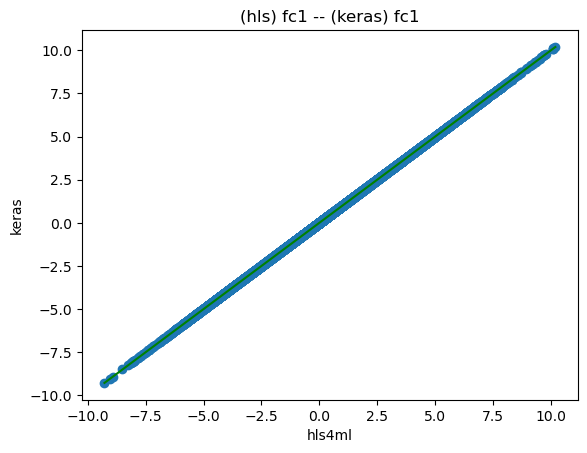

relu1-relu1 		 0.002328125
hls/keras min: 0.0/0.0
hls/keras max: 3.75/3.75


<Figure size 700x500 with 0 Axes>

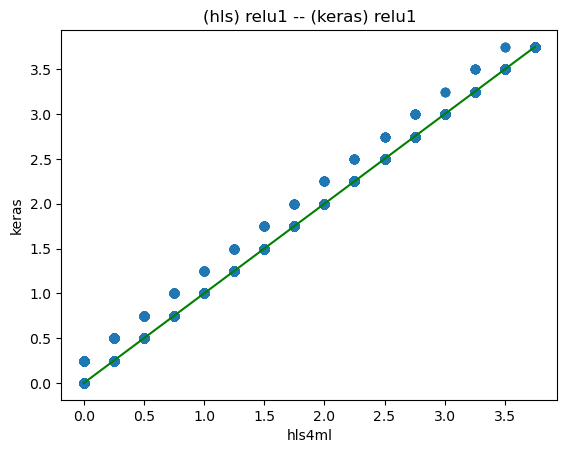

fc2-fc2 		 10.275045
hls/keras min: -16.0/-13.5625
hls/keras max: 15.75/17.9375


<Figure size 700x500 with 0 Axes>

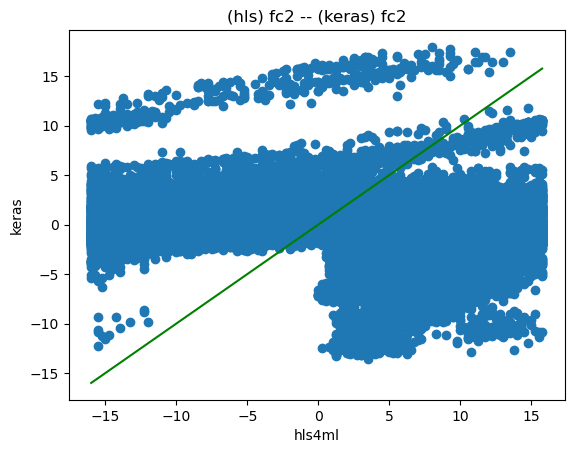

relu2-relu2 		 0.82225
hls/keras min: 0.0/0.0
hls/keras max: 3.75/3.75


<Figure size 700x500 with 0 Axes>

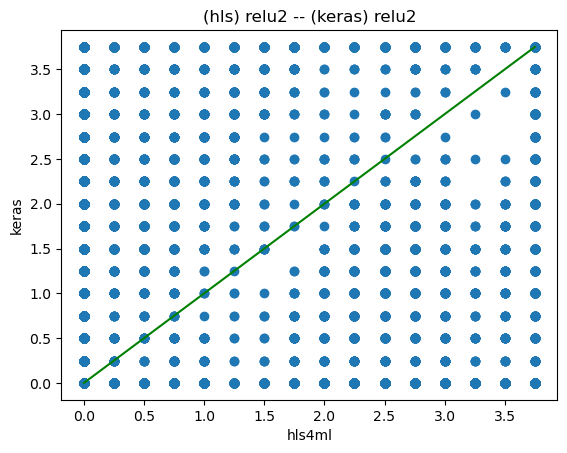

fc3-fc3 		 5.081408
hls/keras min: 0.0/-5.3125
hls/keras max: 17.25/9.25


<Figure size 700x500 with 0 Axes>

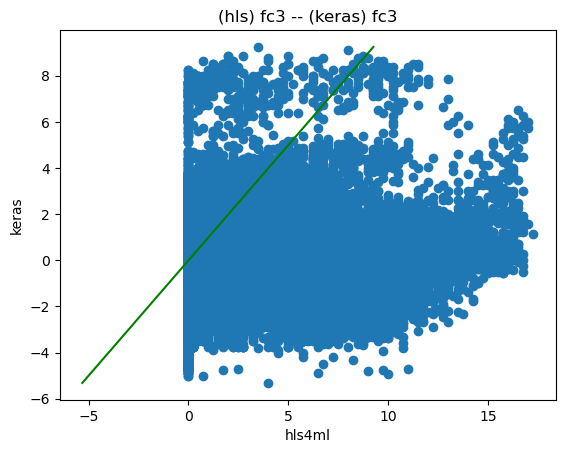

relu3-relu3 		 0.9437109
hls/keras min: 0.0/0.0
hls/keras max: 1.75/1.75


<Figure size 700x500 with 0 Axes>

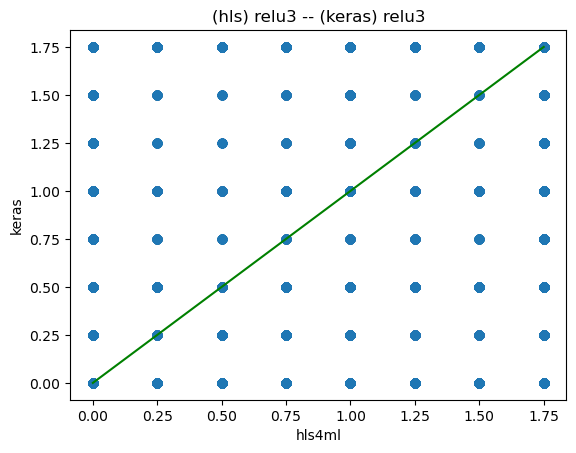

output-output 		 15.799125
hls/keras min: 0.0/-3.0625
hls/keras max: 28.5/5.125


<Figure size 700x500 with 0 Axes>

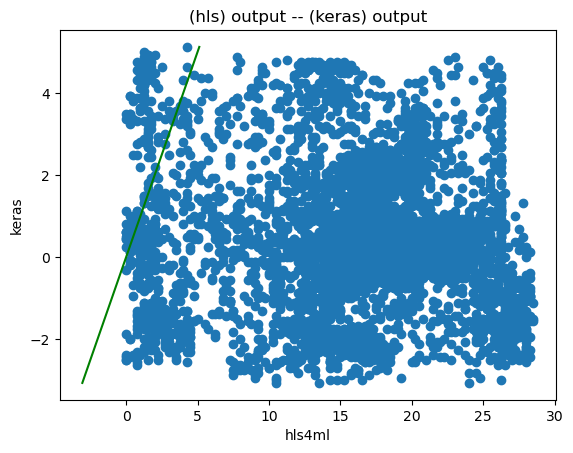

softmax-softmax 		 1.6336209
hls/keras min: -31.3837890625/0.0005616650450974703
hls/keras max: 29.7158203125/0.9886639714241028


<Figure size 700x500 with 0 Axes>

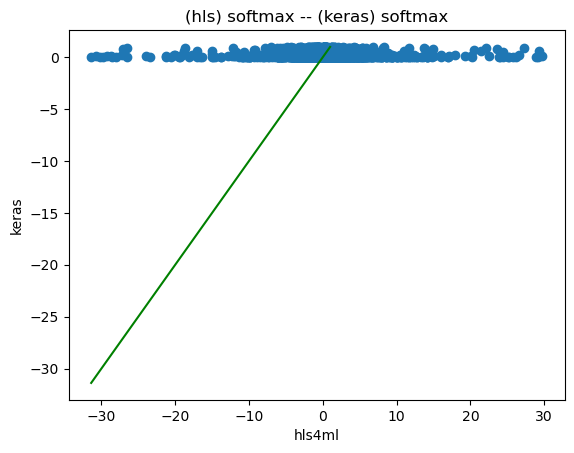

In [145]:
layers = ['fc1', 'relu1', 'fc2', 'relu2', 'fc3', 'relu3', 'output', 'softmax']
for idx, layer in enumerate(layers):
    keras_layer, hls_layer = layer, layer
    try:
        diff = np.average(np.abs(keras_trace[keras_layer] - hls4ml_trace[hls_layer] ))
        print(f'{keras_layer}-{hls_layer}', '\t\t', diff)

        onnx_min, onnx_max = keras_trace[keras_layer].flatten().min(), keras_trace[keras_layer].flatten().max()
        hls_min, hls_max = hls4ml_trace[hls_layer].flatten().min(), hls4ml_trace[hls_layer].flatten().max()
        print(f'hls/keras min: {hls_min}/{onnx_min}')
        print(f'hls/keras max: {hls_max}/{onnx_max}')

        plt.figure(figsize=(7, 5))
        plt.figure()
        plt.scatter(hls4ml_trace[keras_layer].flatten(), keras_trace[hls_layer].flatten())
        min_x = min(keras_trace[keras_layer].min(), hls4ml_trace[hls_layer].min())
        max_x = min(keras_trace[keras_layer].max(), hls4ml_trace[hls_layer].max())
        plt.plot([min_x, max_x], [min_x, max_x], c='green')
        plt.title(f'(hls) {hls_layer} -- (keras) {keras_layer}')
        plt.xlabel('hls4ml')
        plt.ylabel('keras')
        plt.show()
        # plt.savefig(f'../results/{idx}_(hls){hls_layer} -- (keras){keras_layer}.png')
        plt.close()
    except Exception as e:
        print(e)

<Figure size 700x500 with 0 Axes>

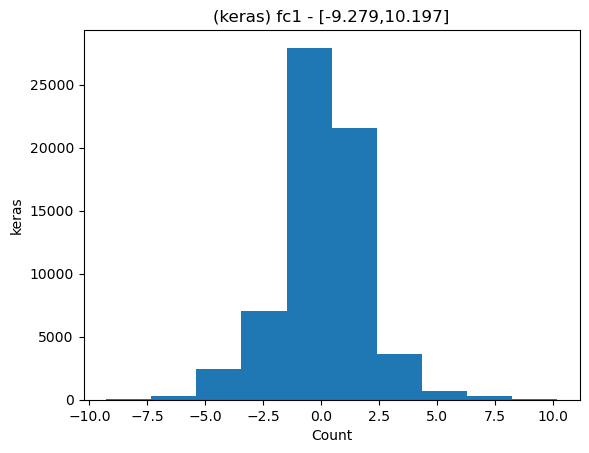

<Figure size 700x500 with 0 Axes>

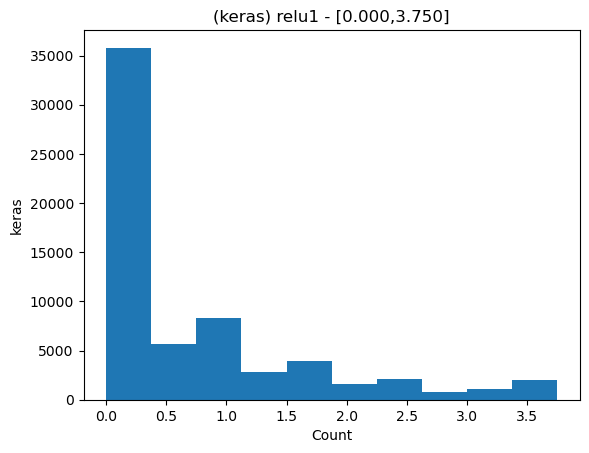

<Figure size 700x500 with 0 Axes>

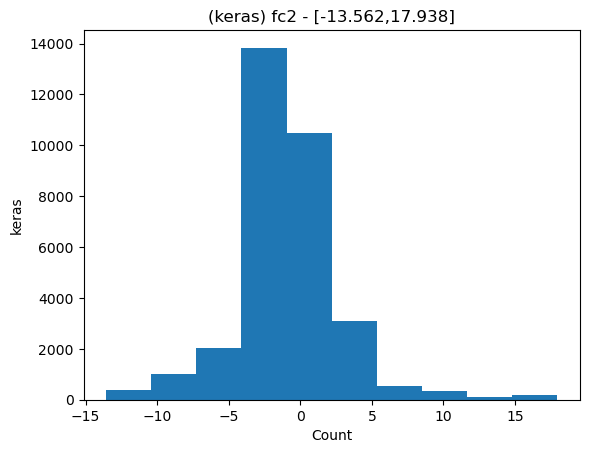

<Figure size 700x500 with 0 Axes>

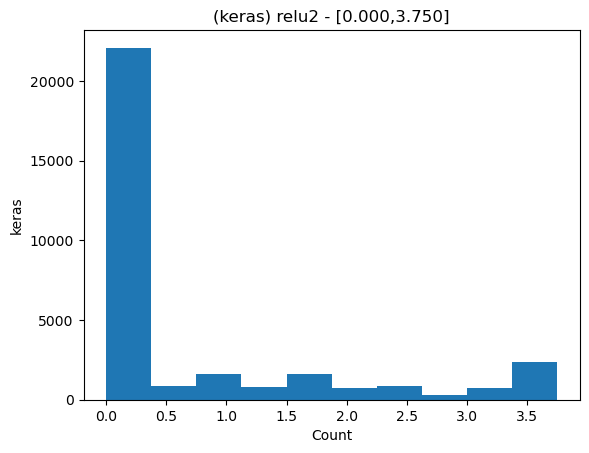

<Figure size 700x500 with 0 Axes>

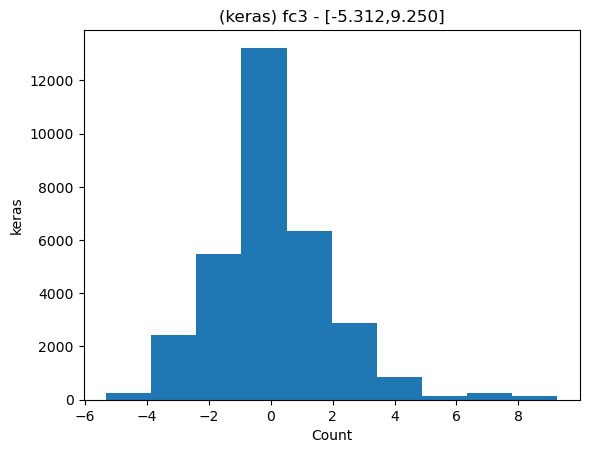

<Figure size 700x500 with 0 Axes>

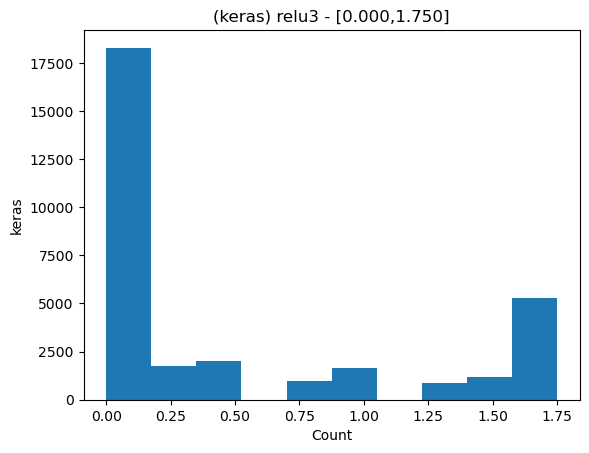

<Figure size 700x500 with 0 Axes>

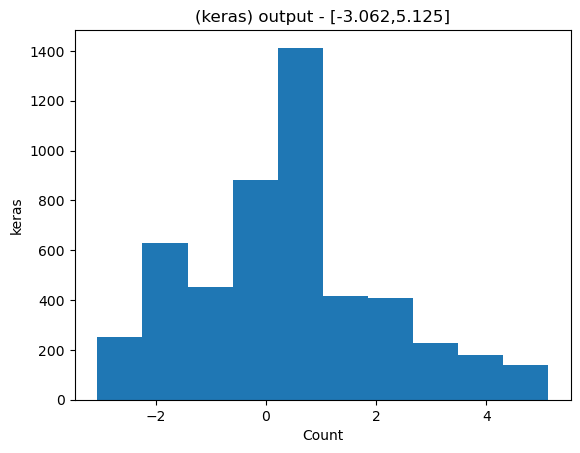

<Figure size 700x500 with 0 Axes>

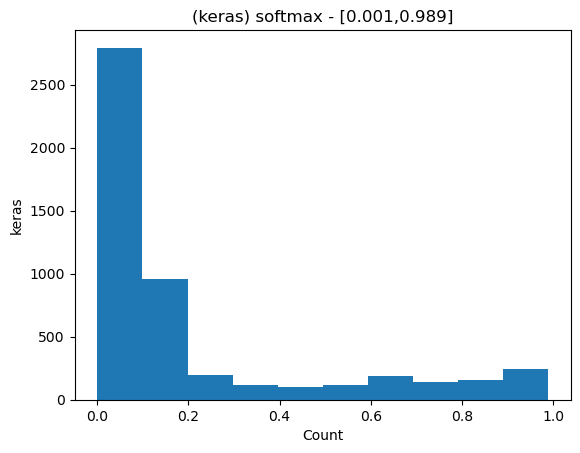

In [146]:
layers = ['fc1', 'relu1', 'fc2', 'relu2', 'fc3', 'relu3', 'output', 'softmax']
for idx, layer in enumerate(layers):
    keras_layer = layer
    try:
        plt.figure(figsize=(7, 5))
        plt.figure()
        plt.hist(keras_trace[keras_layer].flatten())

        keras_min = min(keras_trace[keras_layer].flatten())
        keras_max = max(keras_trace[keras_layer].flatten())
        # plt.scatter(keras_trace[hls_layer].flatten(), keras_trace[keras_layer].flatten())
        # min_x = min(keras_trace[keras_layer][0].min(), hls4ml_trace[hls_layer][0].min())
        # max_x = min(keras_trace[keras_layer][0].max(), hls4ml_trace[hls_layer][0].max())
        # plt.plot([min_x, max_x], [min_x, max_x], c='green')
        plt.title(f'(keras) {keras_layer} - [{keras_min:.3f},{keras_max:.3f}]')
        plt.xlabel('Count')
        plt.ylabel('keras')
        plt.show()
        # plt.savefig(f'../results/{idx}_(hls){hls_layer} -- (keras){keras_layer}.png')
        plt.close()
    except Exception as e:
        print(e)

In [147]:
hls_model.build(csim=False, synth=True, vsynth=True)


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2020.1.1 (64-bit)
  **** SW Build 2960000 on Wed Aug  5 22:57:21 MDT 2020
  **** IP Build 2956692 on Thu Aug  6 01:41:30 MDT 2020
    ** Copyright 1986-2020 Xilinx, Inc. All Rights Reserved.

source /opt/local/Xilinx/Vivado/2020.1/scripts/vivado_hls/hls.tcl -notrace
INFO: Applying HLS Y2K22 patch v1.2 for IP revision
INFO: [HLS 200-10] Running '/opt/local/Xilinx/Vivado/2020.1/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'jcampos' on host 'correlator3.fnal.gov' (Linux_x86_64 version 3.10.0-1160.15.2.el7.x86_64) on Wed Mar 22 22:34:48 CDT 2023
INFO: [HLS 200-10] On os "Scientific Linux release 7.9 (Nitrogen)"
INFO: [HLS 200-10] In directory '/data/jcampos/hawq-jet-tagging/src_keras/hls4ml_prj_qkeras'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-10] Creating and opening project '/data/jcampos/hawq-jet-tagging/src_keras/hls4ml_prj_qkeras/myproject_prj'.
INFO: [HLS 200-10] Adding design file 'firmw

{'EstimatedClockPeriod': '4.371',
 'BestLatency': '12',
 'WorstLatency': '12',
 'IntervalMin': '1',
 'IntervalMax': '1',
 'BRAM_18K': '4',
 'DSP48E': '5',
 'FF': '5637',
 'LUT': '52441',
 'URAM': '0',
 'AvailableBRAM_18K': '5376',
 'AvailableDSP48E': '12288',
 'AvailableFF': '3456000',
 'AvailableLUT': '1728000',
 'AvailableURAM': '1280'}

In [21]:
d = model.get_layer('fc3')

In [25]:
d.get_weights

<bound method Layer.get_weights of <qkeras.qlayers.QDense object at 0x7f2da4609430>>

In [28]:
from qkeras.utils import get_model_sparsity, print_model_sparsity

In [31]:
get_model_sparsity(model, per_layer=True)

... quantizing model


(0.22829801777170197,
 [('fc1', 0.21415441176470587),
  ('fc2', 0.0),
  ('fc3', 0.728219696969697),
  ('output', 0.0)])

In [30]:
print_model_sparsity(model)

Model Sparsity Summary (sequential)
--
fc1: (fc1/kernel:0, 0.2080078125)
fc2: (fc2/kernel:0, 0.0)
fc3: (fc3/kernel:0, 0.7197265625)
output: (output/kernel:0, 0.0)




In [32]:
import math

In [ ]:
m * n * (p * b_a * b_w + b_a + b_w + math.log2(n))

In [35]:
16  * 64 * ((1-0.2080078125) * 16 * 4 + 16 + 4 + math.log2(16))

76480.0

In [36]:
64  * 32 * ((1-0) * 4 * 1 + 4 + 1 + math.log2(64))

30720.0

In [38]:
32  * 32 * ((1-0.7197265625) * 4 * 2 + 4 + 2 + math.log2(32))

13560.0

In [39]:
32  * 5 * ((1-0) * 3 * 1 + 3 + 1 + math.log2(32))


1920.0

In [40]:
76480.0 + 30720.0 + 13560.0 + 1920.0

122680.0